# Classification and analyzis of Dutch train stations

##  Introduction

The Netherlands have an extensive rail network with many stations.

The last years more and more businesses and population are concentrating around stations. Also stations are extended with shops, horeca and office facilities to make them more attractive.

Stations are very different: 
* Major hubs in big cities with many perons and many passengers. 
* Local stations in the country side close to a small town in the middle of the fields.

Dutch railnetwerk in 2018:

<img src="./spoorkaart-2018.jpg" alt="drawing" width="500"/>

## Business Problem 

The question is what are good candidate stations to invest in facilities, like shops or horeca facilities.<br/>
The anwser to this question helps an business invester to make the right investement decisions.<br/>
The goal is analyse and cluster the trainstations in the Netherlands based on the characteristic of the stations and thier neighborhood.

## Data

The required data is:
1. the Dutch train stations and their coordinates
2. the facilities at and around these train stations

The data for point 1) is available at the NS API https://www.ns.nl/en/travel-information/ns-api. The NS is the major Dutch train operator. The API provides an Station section with endpoints to:
* get a list and coordinates of the trainstations
* get details per station.

Regarding point 2) this information is available via the FourSquare API. Via this API we retrieve the facilities very close to the station. Secondly also we retrieve the facilities in the stations neighorhoud, e.g. like horeca and museums. The stations details endpoint of the NS API will also provide details for each station.

In the Foursquare we explore the venues for the following sub-categories:
* Arts & Entertainment (4d4b7104d754a06370d81259)
* College & University (4d4b7105d754a06372d81259)
* Food (4d4b7105d754a06374d81259)
* Nightlife Spot (4d4b7105d754a06376d81259)
* Outdoors & Recreation (4d4b7105d754a06377d81259)
* Professional & Other Places (4d4b7105d754a06375d81259)
* Shop & Service (4d4b7105d754a06378d81259)
* Travel & Transport (4d4b7105d754a06379d81259)

We’ll be querying the number of venues in each category in a 1000m radius around each train station. 1000m is a reasonable walking distance.

Example station data:

In [1]:
import http, urllib, base64
import pandas as pd
import numpy as np
import json
import requests
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

In [2]:
secrets = json.load(open('secrets.json'))

FOURSQUARE_CLIENT_ID = secrets['foursquare']['client_id']
FOURSQUARE_CLIENT_SECRET = secrets['foursquare']['client_secret']
FOURSQUARE_VERSION = secrets['foursquare']['version']
NS_API_KEY = secrets['ns-api']['key']

### Retrieve the stations data

In [3]:
headers = {
    # Request headers
    'Accept-Language': '',
    'Ocp-Apim-Subscription-Key': NS_API_KEY,
}
params = urllib.parse.urlencode({
})

try:
    conn = http.client.HTTPSConnection('gateway.apiportal.ns.nl')
    conn.request("GET", "/ns-international-station-api/nearby?lat={lat}&lon={lon}&k={k}&%s" % params, "{body}", headers)
    response = conn.getresponse()
    data = response.read()
    print(data)
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))                    

b'{ "statusCode": 401, "message": "Access denied due to invalid subscription key. Make sure to provide a valid key for an active subscription." }'


In [4]:
all_stations_df = pd.read_csv('ns_stations.csv')
stations_df = all_stations_df[all_stations_df['Land']=='Netherlands'].reset_index()
stations_df.head(10)

,index,Station,Code,Lat,Lon,Straat,Huisnummer,Postcode,Plaats,Land
0,0,s-Hertogenbosch,HT,51.690480,5.293620,Stationspasserelle,10,5211 AZ,'s-Hertogenbosch,Netherlands
1,1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,Zandzuigerstraat,101,5231 XW,'s-Hertogenbosch,Netherlands
2,2,t Harde,HDE,52.409168,5.893611,Eperweg,123,8084 HD,'t Harde,Netherlands
3,7,Aalten,ATN,51.921327,6.578627,Stationsstraat,38,7122 AT,Aalten,Netherlands
4,8,Abcoude,AC,52.278500,4.977000,Spoorlaan,??,1391,Abcoude,Netherlands
5,12,Akkrum,AKM,53.046391,5.843611,Alde Rykswei,??,8491,Akkrum,Netherlands
6,15,Alkmaar,AMR,52.637779,4.739722,Stationsweg,43B,1815 CB,Alkmaar,Netherlands
7,16,Alkmaar Noord,AMRN,52.643890,4.764167,Drechterwaard,102-104,1824 DX,Alkmaar,Netherlands
8,17,Almelo,AML,52.358055,6.653889,Parallelweg,50,7604 TX,Almelo,Netherlands
9,18,Almelo de Riet,AMRI,52.341946,6.666667,Rietstraat,226,7606 BW,Almelo,Netherlands


### Retrieve the FourSquare venues categories

In [5]:
# categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
#             FOURSQUARE_CLIENT_ID, 
#             FOURSQUARE_CLIENT_SECRET, 
#             FOURSQUARE_VERSION)
            
# # make the GET request
# categories = requests.get(categories_url).json()
# categories

In [6]:
# categories_list=[];
# def parse_categories(categories, level=0, max_level=0): 
    
#     if level>max_level: return
#     out = ''
#     out += '-'*level
#     for category in categories:
#         print("\nCategory: {}".format(category))
#         parse_categories(category['categories'], level+1, max_level)
#         categories_list.append((category['name'], category['id']))
#     return categories_list

# categories_list_df = pd.DataFrame(parse_categories(categories['response']['categories'], 0, 0), columns=["Category", "Id"])
# categories_list_df = categories_list_df[~categories_list_df['Category'].isin(['Event', 'Residence'])].reset_index()
# # categories_list_df.to_csv('categories_list.csv')
# categories_list_df

In [7]:
categories_list_df = pd.read_csv('categories_list.csv')[['Category', 'Id']]
categories_list_df

,Category,Id
0,Arts & Entertainment,4d4b7104d754a06370d81259
1,College & University,4d4b7105d754a06372d81259
2,Food,4d4b7105d754a06374d81259
3,Nightlife Spot,4d4b7105d754a06376d81259
4,Outdoors & Recreation,4d4b7105d754a06377d81259
5,Professional & Other Places,4d4b7105d754a06375d81259
6,Shop & Service,4d4b7105d754a06378d81259
7,Travel & Transport,4d4b7105d754a06379d81259


In [69]:
shops_categories = ['Food', 'Shop & Service']
shops_categories_df = categories_list_df[categories_list_df['Category'].isin(shops_categories)].reset_index()
shops_categories_df

,index,Category,Id
0,2,Food,4d4b7105d754a06374d81259
1,6,Shop & Service,4d4b7105d754a06378d81259


Count the number of venues per category per station

In [9]:
# # Create a dedicated dataframe to store venues data
# stations_venues_df = stations_df[['Station', 'Code', 'Lat', 'Lon']].copy()
# # # stations_venues_df = stations_df.copy()
# for c in categories_list_df['Category']:
#     stations_venues_df[c] = 0
    
stations_venues_df = pd.read_csv('stations_venues_df.csv')
stations_venues_df = stations_venues_df.loc[:, ~stations_venues_df.columns.str.contains('^Unnamed')]
stations_venues_df.head(10)

,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,StationVenues
0,s-Hertogenbosch,HT,51.690480,5.293620,17,26,102,41,31,54,101,24,19.0
1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,9,7,9,4,12,24,21,6,0.0
2,t Harde,HDE,52.409168,5.893611,1,0,5,1,6,4,2,3,1.0
3,Aalten,ATN,51.921327,6.578627,1,2,7,12,11,6,10,2,1.0
4,Abcoude,AC,52.278500,4.977000,3,3,5,7,6,9,4,4,2.0
5,Akkrum,AKM,53.046391,5.843611,0,4,5,2,4,6,4,6,0.0
6,Alkmaar,AMR,52.637779,4.739722,13,6,46,14,11,45,73,14,12.0
7,Alkmaar Noord,AMRN,52.643890,4.764167,1,2,8,1,7,19,6,7,5.0
8,Almelo,AML,52.358055,6.653889,4,2,38,9,6,31,64,10,2.0
9,Almelo de Riet,AMRI,52.341946,6.666667,5,7,7,3,5,9,8,6,2.0


### Retrieve the venue counts from FourSquare

In [10]:
def get_venue_count(lat, lon, radius, categoryId):
    # print("categoryId: {}".format(categoryId))
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                FOURSQUARE_CLIENT_ID, 
                FOURSQUARE_CLIENT_SECRET, 
                FOURSQUARE_VERSION,
                lat,
                lon,
                radius,
                categoryId)
    # print("  explore_url:", explore_url)

    # make the GET request
    resp = requests.get(explore_url)
    # print("response: {}", resp.json())
    # print("  resp:", resp)
    return int(resp.json()['response']['totalResults'])

In [11]:
# #Request number of venues, store result as CSV
# surrounding_radius = 1000
# for i, row in stations_venues_df.iterrows():
#     if i>=79:
#         print(i)
#         for ci, catrow in categories_list_df.iterrows():
#         # for c in categories_list_df['Category']:
#             catId = catrow['Id']
#             try:
#                 stations_venues_df.loc[i, catrow['Category']] = get_venue_count(stations_venues_df['Lat'].iloc[i], stations_venues_df['Lon'].iloc[i], radius=surrounding_radius, categoryId=catId)
#             except:
#                 stations_venues_df.loc[i, catrow['Category']] = get_venue_count(stations_venues_df['Lat'].iloc[i], stations_venues_df['Lon'].iloc[i], radius=surrounding_radius, categoryId=catId)
# #    stations_venues_df.to_csv('stations_venues.csv')

# stations_venues_df

In [35]:
#Request number of venues, store result as CSV
station_radius = 150
column_name = 'Station_'
# vanues_categories_df = categories_list_df[categories_list_df['Category'].isin(['Food', 'Shop & Service'])]
stations_local_venues_df = pd.DataFrame()

for i, row in stations_venues_df.iterrows():
    if i>=0:
        print(i)
        for ci, catrow in shops_categories_df.iterrows():
        # for c in categories_list_df['Category']:
            catId = catrow['Id']
            print("  {}".format(catrow['Category']))
            try:
                stations_local_venues_df.loc[i, column_name+catrow['Category']] = get_venue_count(stations_venues_df['Lat'].iloc[i], stations_venues_df['Lon'].iloc[i], radius=station_radius, categoryId=catId)
            except:
                stations_local_venues_df.loc[i, column_name+catrow['Category']] = get_venue_count(stations_venues_df['Lat'].iloc[i], stations_venues_df['Lon'].iloc[i], radius=station_radius, categoryId=catId)

# stations_local_venues_df

stations_venues_df['StationVenues'] = stations_local_venues_df.sum(axis=1).astype(int)
stations_venues_df.to_csv('stations_venues.csv')
stations_venues_df

,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,StationVenues
0,s-Hertogenbosch,HT,51.690480,5.293620,17,26,102,41,31,54,101,24,19.0
1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,9,7,9,4,12,24,21,6,0.0
2,t Harde,HDE,52.409168,5.893611,1,0,5,1,6,4,2,3,1.0
3,Aalten,ATN,51.921327,6.578627,1,2,7,12,11,6,10,2,1.0
4,Abcoude,AC,52.278500,4.977000,3,3,5,7,6,9,4,4,2.0
5,Akkrum,AKM,53.046391,5.843611,0,4,5,2,4,6,4,6,0.0
6,Alkmaar,AMR,52.637779,4.739722,13,6,46,14,11,45,73,14,12.0
7,Alkmaar Noord,AMRN,52.643890,4.764167,1,2,8,1,7,19,6,7,5.0
8,Almelo,AML,52.358055,6.653889,4,2,38,9,6,31,64,10,2.0
9,Almelo de Riet,AMRI,52.341946,6.666667,5,7,7,3,5,9,8,6,2.0


In [46]:
stations_venues_df = pd.read_csv('stations_venues.csv')
stations_venues_df = stations_venues_df.loc[:, ~stations_venues_df.columns.str.contains('^Unnamed')]
stations_venues_df.head(10)

,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,StationVenues
0,s-Hertogenbosch,HT,51.690480,5.293620,17,26,102,41,31,54,101,24,19
1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,9,7,9,4,12,24,21,6,0
2,t Harde,HDE,52.409168,5.893611,1,0,5,1,6,4,2,3,1
3,Aalten,ATN,51.921327,6.578627,1,2,7,12,11,6,10,2,1
4,Abcoude,AC,52.278500,4.977000,3,3,5,7,6,9,4,4,2
5,Akkrum,AKM,53.046391,5.843611,0,4,5,2,4,6,4,6,0
6,Alkmaar,AMR,52.637779,4.739722,13,6,46,14,11,45,73,14,12
7,Alkmaar Noord,AMRN,52.643890,4.764167,1,2,8,1,7,19,6,7,5
8,Almelo,AML,52.358055,6.653889,4,2,38,9,6,31,64,10,2
9,Almelo de Riet,AMRI,52.341946,6.666667,5,7,7,3,5,9,8,6,2


In [79]:
 stations_venues_df[stations_venues_df.isnull().any(axis=1)]

,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,StationVenues
258,Nieuw Amsterdam,NaN,52.718613,6.848611,1,0,4,4,4,4,13,2,2


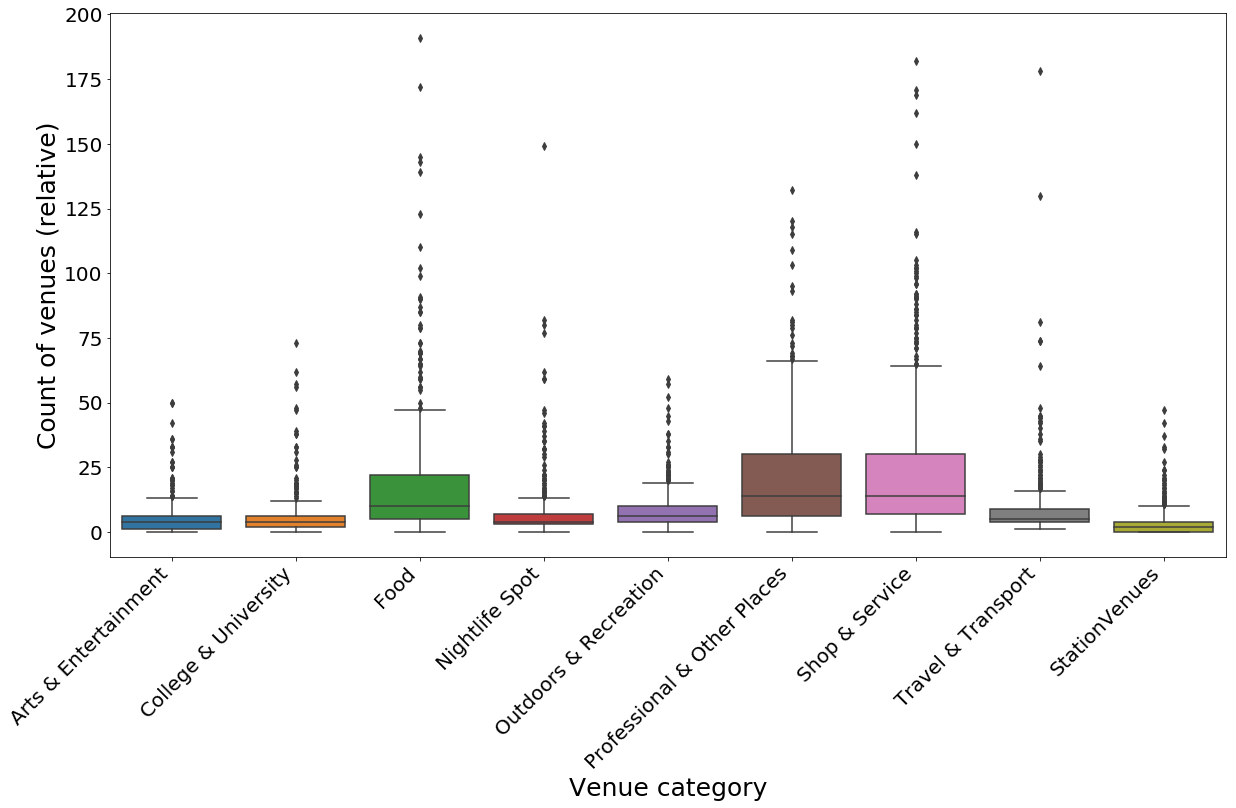

In [48]:
stations_venues_plot_df = stations_venues_df.copy().drop(['Lat', 'Lon', 'Station', 'Code'], axis=1)

plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot
ax = sns.boxplot(data = stations_venues_plot_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

C:\Users\Arjan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


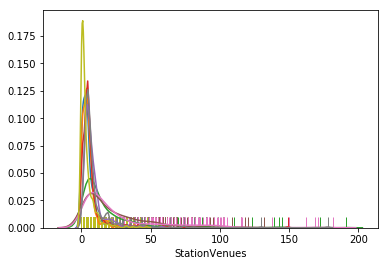

In [49]:
#lines = stations_venues_plot_df.plot.line()
for col in stations_venues_plot_df.columns:
    sns.distplot(stations_venues_plot_df[col], hist=False, rug=True)

## Data preparation¶

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

columns = stations_venues_df.drop(columns=station_cols).columns[4:]
X = stations_venues_df.values[:,4:]
vanue_counts_norm = MinMaxScaler().fit_transform(X)
# vanue_counts_norm = RobustScaler().fit_transform(X)
# vanue_counts_norm = PowerTransformer(method='yeo-johnson').fit_transform(X)
print("columns: {}".format(columns))
print("X: {}".format(X))
print("vanue_counts_norm: {}".format(vanue_counts_norm))

columns: Index(['Arts & Entertainment', 'College & University', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Shop & Service', 'Travel & Transport',
       'StationVenues'],
      dtype='object')
X: [[17 26 102 ... 101 24 19]
 [9 7 9 ... 21 6 0]
 [1 0 5 ... 2 3 1]
 ...
 [1 0 3 ... 15 2 1]
 [2 4 19 ... 18 7 4]
 [4 20 69 ... 79 25 12]]
vanue_counts_norm: [[0.34       0.35616438 0.53403141 ... 0.55494505 0.1299435  0.40425532]
 [0.18       0.09589041 0.04712042 ... 0.11538462 0.02824859 0.        ]
 [0.02       0.         0.02617801 ... 0.01098901 0.01129944 0.0212766 ]
 ...
 [0.02       0.         0.01570681 ... 0.08241758 0.00564972 0.0212766 ]
 [0.04       0.05479452 0.09947644 ... 0.0989011  0.03389831 0.08510638]
 [0.08       0.2739726  0.36125654 ... 0.43406593 0.13559322 0.25531915]]


C:\Users\Arjan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
# vanue_counts_norm

In [51]:
vanue_counts_norm_df = pd.DataFrame(vanue_counts_norm, columns=columns)
#cluster_df.columns = [c in categories_list_df['Category']]
vanue_counts_norm_df.head(10)

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,StationVenues
0,0.34,0.356164,0.534031,0.275168,0.525424,0.409091,0.554945,0.129944,0.404255
1,0.18,0.095890,0.047120,0.026846,0.203390,0.181818,0.115385,0.028249,0.000000
2,0.02,0.000000,0.026178,0.006711,0.101695,0.030303,0.010989,0.011299,0.021277
3,0.02,0.027397,0.036649,0.080537,0.186441,0.045455,0.054945,0.005650,0.021277
4,0.06,0.041096,0.026178,0.046980,0.101695,0.068182,0.021978,0.016949,0.042553
5,0.00,0.054795,0.026178,0.013423,0.067797,0.045455,0.021978,0.028249,0.000000
6,0.26,0.082192,0.240838,0.093960,0.186441,0.340909,0.401099,0.073446,0.255319
7,0.02,0.027397,0.041885,0.006711,0.118644,0.143939,0.032967,0.033898,0.106383
8,0.08,0.027397,0.198953,0.060403,0.101695,0.234848,0.351648,0.050847,0.042553
9,0.10,0.095890,0.036649,0.020134,0.084746,0.068182,0.043956,0.028249,0.042553


In [52]:
vanue_counts_norm_df.shape

(413, 9)

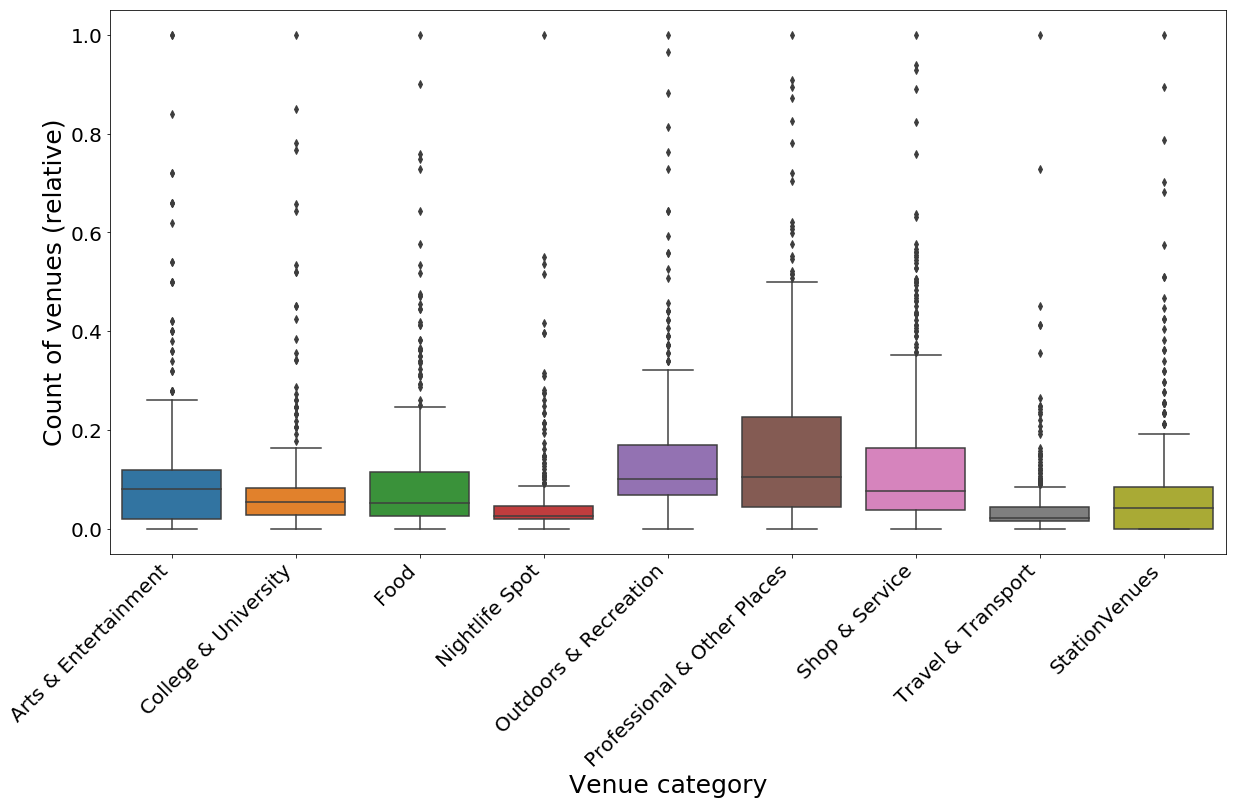

In [53]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = vanue_counts_norm_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [58]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vanue_counts_norm_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
# replace_labels = {0:2, 1:0, 2:3, 3:1}
# for i in range(len(kmeans_labels)):
#     kmeans_labels[i] = replace_labels[kmeans_labels[i]]

In [67]:
stations_clusters_df = vanue_counts_norm_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels
# stations_clusters_counts_df['Cluster'] = kmeans_labels
# stations_clusters_counts_df['Station'] = stations_df['Station']
# stations_clusters_counts_df['Lat'] = stations_df['Lat']
# stations_clusters_counts_df['Lon'] = stations_df['Lon']

stations_clusters_counts_df = stations_venues_df.copy()
stations_clusters_counts_df['Cluster'] = kmeans_labels
stations_clusters_counts_df['Station'] = stations_df['Station']
stations_clusters_counts_df['Lat'] = stations_df['Lat']
stations_clusters_counts_df['Lon'] = stations_df['Lon']
stations_clusters_counts_df

,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,StationVenues,Cluster
0,s-Hertogenbosch,HT,51.690480,5.293620,17,26,102,41,31,54,101,24,19,1
1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,9,7,9,4,12,24,21,6,0,2
2,t Harde,HDE,52.409168,5.893611,1,0,5,1,6,4,2,3,1,0
3,Aalten,ATN,51.921327,6.578627,1,2,7,12,11,6,10,2,1,0
4,Abcoude,AC,52.278500,4.977000,3,3,5,7,6,9,4,4,2,0
5,Akkrum,AKM,53.046391,5.843611,0,4,5,2,4,6,4,6,0,0
6,Alkmaar,AMR,52.637779,4.739722,13,6,46,14,11,45,73,14,12,2
7,Alkmaar Noord,AMRN,52.643890,4.764167,1,2,8,1,7,19,6,7,5,0
8,Almelo,AML,52.358055,6.653889,4,2,38,9,6,31,64,10,2,2
9,Almelo de Riet,AMRI,52.341946,6.666667,5,7,7,3,5,9,8,6,2,0


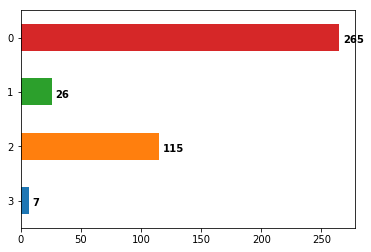

In [60]:
# pd.DataFrame(kmeans_labels, columns=['Category'])['Category'].value_counts().plot(kind='barh')
label_counts = pd.Series(kmeans_labels).value_counts().sort_index(ascending =False)
ax = label_counts.plot(kind='barh')
for i, v in enumerate(label_counts):
    ax.text(v + 3, i - .1, str(v), color='black', fontweight='bold')

In [61]:
for c in range(kclusters):
    stations = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster']==c]
    print("c: {} - #stations: {}".format(c, len(stations)))
    print("        stations:\n{}".format(stations['Station']))

c: 0 - #stations: 265
        stations:
2                        t Harde
3                         Aalten
4                        Abcoude
5                         Akkrum
7                  Alkmaar Noord
9                 Almelo de Riet
13           Almere Oostvaarders
14               Almere Parkwijk
15                  Almere Poort
19           Amersfoort Vathorst
31                 Anna Paulowna
33            Apeldoorn De Maten
34            Apeldoorn Osseveld
35                    Appingedam
36                         Arkel
37                    Arnemuiden
41                   Arnhem Zuid
44              Bad Nieuweschans
45                         Baflo
48               Barneveld Noord
49                Barneveld Zuid
50                         Bedum
51                   Beek-Elsloo
52                         Beesd
53                        Beilen
60                    Bodegraven
61                         Borne
62                       Boskoop
63             Boven-Hardinxveld
64 

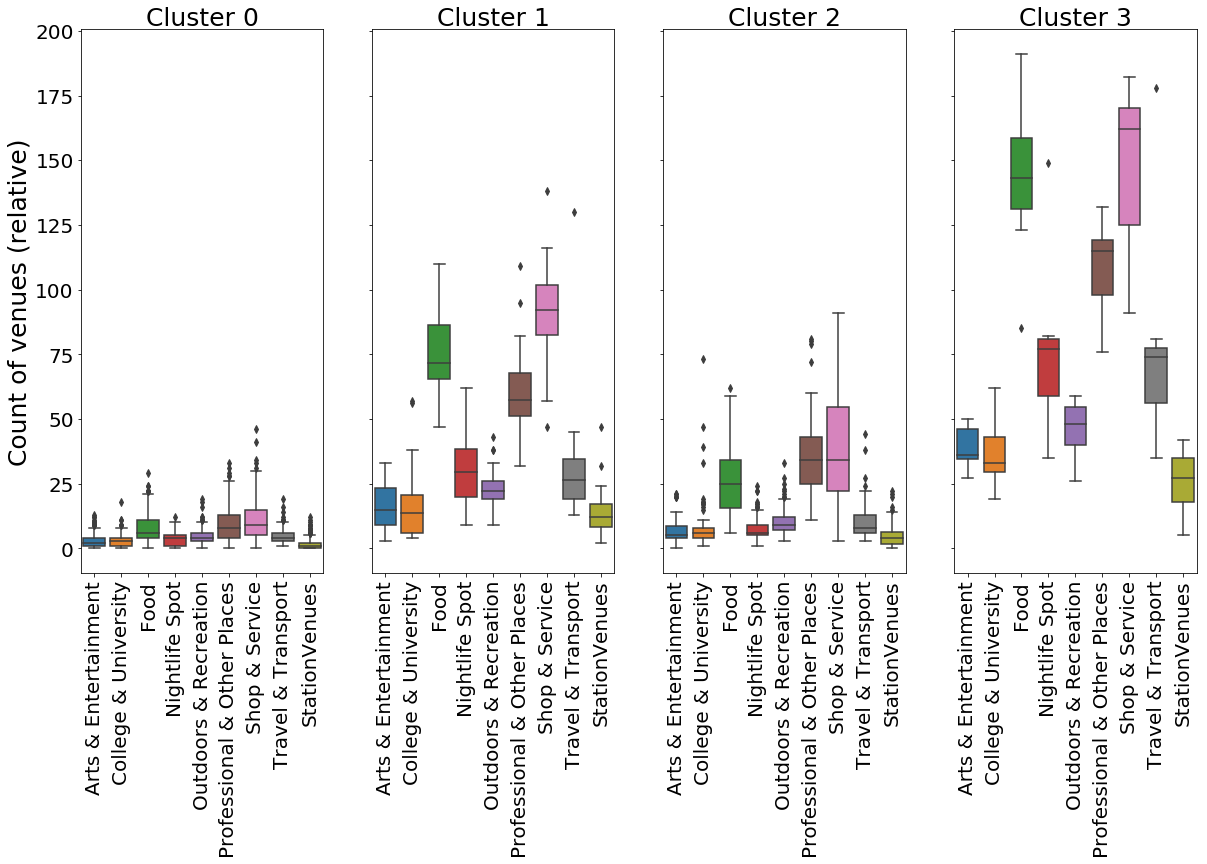

In [62]:
import matplotlib.ticker as ticker

stations_clusters_plot_df = stations_clusters_minmax_df.copy().drop(['Lat', 'Lon'], axis=1)

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    #axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_plot_df[stations_clusters_plot_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [63]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
location = 'Netherlands'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(location)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(location, latitude, longitude))

The geograpical coordinate of Nederland are 52.24726925, 5.54122345487672.


In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_clusters_minmax_df['Lat'], 
                                  stations_clusters_minmax_df['Lon'], 
                                  stations_clusters_minmax_df['Station'], 
                                  stations_clusters_minmax_df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Calculate area/station shop ratio

In [82]:
stations_shops_df = pd.DataFrame()
stations_shops_df['Station'] = stations_clusters_counts_df['Station']
stations_shops_df['StationShops'] = stations_clusters_counts_df['StationVenues']
stations_shops_df['AreaShops'] =  stations_clusters_counts_df[shops_categories].sum(axis=1)
stations_shops_df['Ratio'] = stations_shops_df['StationShops']/stations_shops_df['AreaShops']
# stations_shops_df['Ratio'] = stations_shops_df['Ratio'].fillna(0, inplace=True)
stations_shops_df = stations_shops_df.sort_values(by='Ratio')

stations_shops_df

,Station,StationShops,AreaShops,Ratio
131,Enkhuizen,0,45,0.000000
127,Eindhoven Strijp-S,0,47,0.000000
130,Emmen Zuid,0,3,0.000000
138,Eygelshoven,0,8,0.000000
139,Eygelshoven Markt,0,9,0.000000
326,Spaubeek,0,12,0.000000
143,Geerdijk,0,1,0.000000
125,Eindh Beukenln tot 13 dec,0,47,0.000000
322,Sneek Noord,0,69,0.000000
320,Sliedrecht Baanhoek,0,12,0.000000
